In [4]:
%load_ext autoreload

%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import problem
import jax.numpy as jnp
import jax.scipy as jsp
import jax
import matplotlib.pyplot as plt
import yaml



#from problem import *

In [6]:
with open('config_basic.yml', 'r') as file:
        c = yaml.safe_load(file)

# Create spatial discretisation 
lat_first = c['spatial_discretisation']['lat_first']
lat_final = c['spatial_discretisation']['lat_final']
lat_n     = c['spatial_discretisation']['lat_n']
lng_first = c['spatial_discretisation']['lng_first']
lng_final = c['spatial_discretisation']['lng_final']
lng_n     = c['spatial_discretisation']['lng_n']

lat,lng = jnp.mgrid[lat_first:lat_final:lat_n*1j,
                    lng_first:lng_final:lng_n*1j]

# Test boundary aware functional equations

In [259]:
DTHETA, DLAMBDA = 1,1

class BoundaryAware():

    def __init__(self, state, neighbours):
        self.state = state
        self.nbs = neighbours

    def laplacian(self, y):
        return self.divergence(self.gradient(y)) +  y*(1-self.state)
        
        
        yb = y*self.state

        y_i_next = jnp.roll(yb, shift=1, axis=-2)
        y_i_prev = jnp.roll(yb, shift=-1,axis=-2)
        y_j_next = jnp.roll(yb, shift=1 ,axis=-1)
        y_j_prev = jnp.roll(yb, shift=-1,axis=-1)
        return  y*(1-self.state) + self.state*(y_j_next #
                                            + y_i_next
                                            - self.nbs * yb 
                                            + y_j_prev 
                                            + y_i_prev) / (DTHETA*DLAMBDA)
                                            
    
    def ptheta(self, y):
        y_i_next = jnp.roll(y, shift=1, axis=-2)
        y_i_prev = jnp.roll(y, shift=-1,axis=-2)

        f_i_next = jnp.roll(self.state, shift=1, axis=-2)
        f_i_prev = jnp.roll(self.state, shift=-1,axis=-2)

        return self.state * ( # there is only a valid derivative in fluid cells
                 f_i_next * f_i_prev     * (y_i_next - y_i_prev) / 2  # case where both neighbours are fluid
               + f_i_next * (1-f_i_prev) * (y_i_next/2)             # case where only the next neighbour is fluid
               + (1-f_i_next) * f_i_prev * (- y_i_prev/2)             # case where only the previous neighbour is fluid
            )/DTHETA                                        # when neither neighbour is fluid, the previous two cases cancel out
             
    def plambda(self, y): 
        y_j_next = jnp.roll(y, shift=1, axis=-1)
        y_j_prev = jnp.roll(y, shift=-1,axis=-1)

        f_j_next = jnp.roll(self.state, shift=1, axis=-1)
        f_j_prev = jnp.roll(self.state, shift=-1,axis=-1)

        return self.state * (  # there is only a valid derivative in fluid cells
                 f_j_next * f_j_prev     * (y_j_next - y_j_prev) / 2  # case where both neighbours are fluid
               + f_j_next * (1-f_j_prev) * (y_j_next/2)             # case where only the next neighbour is fluid
               + (1-f_j_next) * f_j_prev * ( - y_j_prev/2)             # case where only the previous neighbour is fluid
            )/DTHETA                                        # when neither neighbour is fluid, the previous two cases cancel out

    def gradient(self, y):
        return jnp.array( (self.ptheta(y), self.plambda(y)))
    
    def divergence(self, v):

        return self.ptheta(v[0]) + self.plambda(v[1])
    
        v_i_next = jnp.roll(v[0], shift=1, axis=-2)
        v_i_prev = jnp.roll(v[0], shift=-1,axis=-2)
        v_j_next = jnp.roll(v[1], shift=1 ,axis=-1)
        v_j_prev = jnp.roll(v[1], shift=-1,axis=-1)
        return (v_i_next - v_i_prev + v_j_next - v_j_prev) #*self.state

In [189]:
def neighbours(state):
    s_i_next = jnp.roll(state, shift=1, axis=-2)
    s_i_prev = jnp.roll(state, shift=-1,axis=-2)
    s_j_next = jnp.roll(state, shift=1 ,axis=-1)
    s_j_prev = jnp.roll(state, shift=-1,axis=-1)

    return s_i_next + s_i_prev + s_j_next + s_j_prev

In [229]:
v = jnp.zeros((2, lat.shape[0], lat.shape[1]))
v = v.at[1].set( -1 * ((jnp.square(lat+0.5) + jnp.square(lng+0.5))<1) )

state = 1 - 1 * ((jnp.square(lat+0.5) + jnp.square(lng+2))<0.7)
state_neighbours = neighbours(state)*state

v *= state
ba = BoundaryAware(state, state_neighbours)

Text(0.5, 1.0, 'purple solid, yellow fluid')

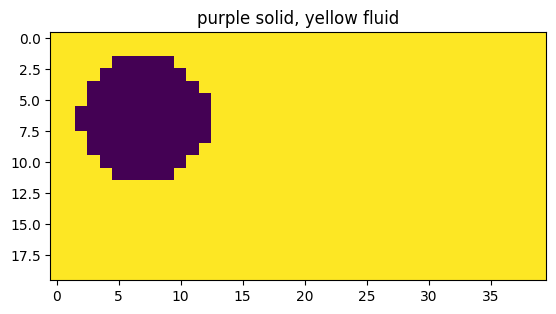

In [198]:
plt.imshow(state)
plt.title('purple solid, yellow fluid')

Text(0.5, 1.0, ' horizontal derivative of horizontal velocity')

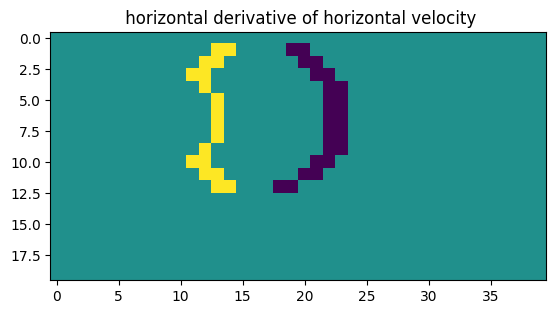

In [199]:
plt.imshow(ba.plambda(v[1]))
plt.title(' horizontal derivative of horizontal velocity')

Text(0.5, 1.0, 'laplacian of horizontal velocity')

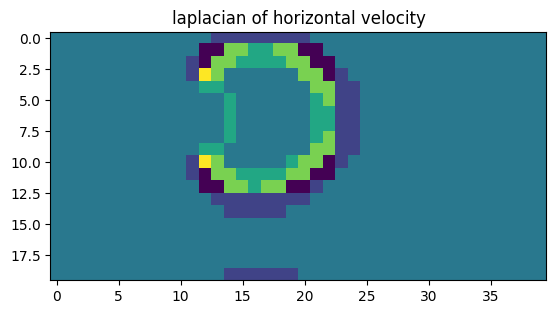

In [200]:
plt.imshow(ba.laplacian(v[1]))
plt.title('laplacian of horizontal velocity')

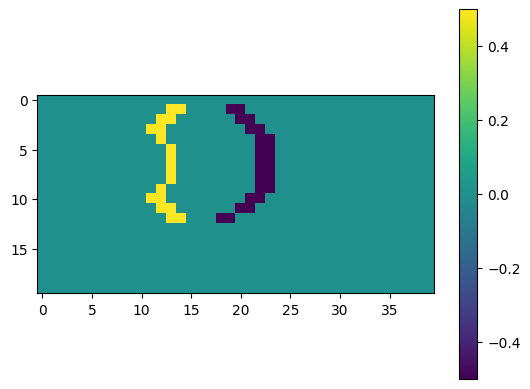

In [201]:
plt.imshow(ba.divergence(v) )
plt.colorbar()

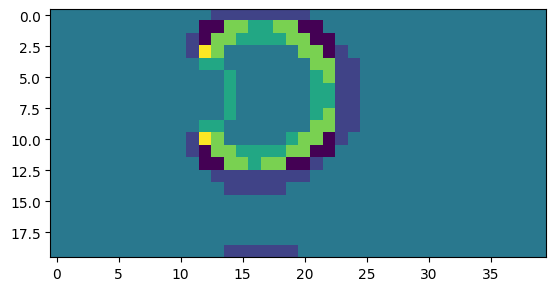

In [202]:
plt.imshow( ba.divergence( ba.gradient(v[1])))

# eval  stuff

In [158]:
def flatten_linop(f, from_shape):
    return lambda x: f( x.reshape(from_shape) ).flatten()

# Compute jacobian of ba.laplacian
flat_laplacian = flatten_linop(ba.laplacian, (20,40))
jacobian_laplacian = jax.jacobian(flat_laplacian)


flat_divgrad = flatten_linop( lambda x: ba.divergence(ba.gradient(x)), (20,40))
jacobian_divgrad = jax.jacobian(flat_divgrad)

In [159]:
print(jnp.unique( ba.gradient(jnp.ones((20,40))), return_counts=True ))

(Array([0.], dtype=float32), Array([1600], dtype=int32))


In [161]:
raw_lap_matrix0 = jacobian_laplacian(jnp.zeros(20*40))
raw_lap_matrix1 = jacobian_laplacian(jnp.ones(20*40))

In [162]:
# Show there are no next flows in either direction 
raw_lap_matrix0.sum(axis = 1).any()

Array(False, dtype=bool)

In [163]:
first_points, second_points = jnp.where(raw_lap_matrix0 - raw_lap_matrix0.T)

In [164]:
raw_lap_matrix0[first_points, second_points]

Array([ 0.25,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.25,  0.25,  0.5 ,
       -1.  ,  0.5 , -1.  ,  0.5 , -1.  ,  0.5 , -1.  ,  0.5 , -1.  ,
        0.5 ,  0.5 ,  0.25,  0.25,  0.5 ,  0.5 ,  0.5 , -1.  ,  0.5 ,
       -1.  ,  0.5 , -1.  , -1.  ,  0.5 ,  0.5 ,  0.5 ,  0.25,  0.25,
        0.25,  0.5 ,  0.25,  0.5 , -1.  ,  0.5 , -1.  ,  0.5 , -1.  ,
       -1.  ,  0.5 ,  0.5 ,  0.5 ,  0.25,  0.25,  0.5 ,  0.5 , -1.  ,
        0.5 ,  0.5 , -1.  , -1.  ,  0.5 ,  0.5 ,  0.25,  0.25,  0.5 ,
        0.5 , -1.  ,  0.5 , -1.  , -1.  ,  0.5 ,  0.5 ,  0.25,  0.5 ,
       -1.  ,  0.5 , -1.  ,  0.5 ,  0.5 ,  0.25,  0.25,  0.5 , -1.  ,
        0.5 , -1.  ,  0.5 ,  0.5 ,  0.25,  0.25,  0.25,  0.5 ,  0.5 ,
       -1.  , -1.  ,  0.5 , -1.  ,  0.5 ,  0.5 ,  0.25,  0.25,  0.5 ,
        0.5 ,  0.5 , -1.  , -1.  ,  0.5 , -1.  ,  0.5 ,  0.5 ,  0.25,
        0.25,  0.25,  0.5 ,  0.5 , -1.  , -1.  ,  0.5 , -1.  ,  0.5 ,
       -1.  ,  0.5 ,  0.5 ,  0.5 ,  0.25,  0.25,  0.5 ,  0.5 ,  0.5 ,
       -1.  , -1.  ,

In [165]:
raw_lap_matrix0[second_points, first_points]

Array([ 0.5 , -1.  , -1.  , -1.  , -1.  , -1.  ,  0.5 ,  0.5 , -1.  ,
        0.5 ,  0.25,  0.5 ,  0.25,  0.5 ,  0.25,  0.5 ,  0.25,  0.5 ,
        0.25, -1.  ,  0.5 ,  0.5 , -1.  , -1.  ,  0.25,  0.5 ,  0.25,
        0.5 ,  0.25,  0.5 ,  0.5 ,  0.25, -1.  , -1.  ,  0.5 ,  0.5 ,
        0.5 , -1.  ,  0.5 ,  0.25,  0.5 ,  0.25,  0.5 ,  0.25,  0.5 ,
        0.5 ,  0.25, -1.  , -1.  ,  0.5 ,  0.5 , -1.  ,  0.25,  0.5 ,
       -1.  ,  0.25,  0.5 ,  0.5 ,  0.25, -1.  ,  0.5 ,  0.5 , -1.  ,
        0.25,  0.5 ,  0.25,  0.5 ,  0.5 ,  0.25, -1.  ,  0.5 , -1.  ,
        0.5 ,  0.25,  0.5 ,  0.25, -1.  ,  0.5 ,  0.5 , -1.  ,  0.5 ,
        0.25,  0.5 ,  0.25, -1.  ,  0.5 ,  0.5 ,  0.5 , -1.  ,  0.25,
        0.5 ,  0.5 ,  0.25,  0.5 ,  0.25, -1.  ,  0.5 ,  0.5 , -1.  ,
       -1.  ,  0.25,  0.5 ,  0.5 ,  0.25,  0.5 ,  0.25, -1.  ,  0.5 ,
        0.5 ,  0.5 , -1.  ,  0.25,  0.5 ,  0.5 ,  0.25,  0.5 ,  0.25,
        0.5 ,  0.25, -1.  , -1.  ,  0.5 ,  0.5 , -1.  , -1.  ,  0.25,
        0.5 ,  0.5 ,

In [166]:
resuling_matrix = jacobian_laplacian(jnp.ones(20*40))
resuling_matrix2 = jacobian_laplacian(jnp.zeros(20*40))

In [167]:
resuling_matrix

Array([[-1.  ,  0.  ,  0.25, ...,  0.  ,  0.  ,  0.  ],
       [ 0.  , -1.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.25,  0.  , -1.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ..., -1.  ,  0.  ,  0.25],
       [ 0.  ,  0.  ,  0.  , ...,  0.  , -1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.25,  0.  , -1.  ]], dtype=float32)

In [132]:
import numpy as np
def quatromatrix(left, bottom, right, top, ax=None, triplotkw={},tripcolorkw={}):
    if not ax: ax=plt.gca()
    n = left.shape[0]; m=left.shape[1]

    a = np.array([[0,0],[0,1],[.5,.5],[1,0],[1,1]])
    tr = np.array([[0,1,2], [0,2,3],[2,3,4],[1,2,4]])

    A = np.zeros((n*m*5,2))
    Tr = np.zeros((n*m*4,3))

    for i in range(n):
        for j in range(m):
            k = i*m+j
            A[k*5:(k+1)*5,:] = np.c_[a[:,0]+j, a[:,1]+i]
            Tr[k*4:(k+1)*4,:] = tr + k*5

    C = np.c_[ left.flatten(), bottom.flatten(), 
              right.flatten(), top.flatten()   ].flatten()

    triplot = ax.triplot(A[:,0], A[:,1], Tr, **triplotkw)
    tripcolor = ax.tripcolor(A[:,0], A[:,1], Tr, facecolors=C, **tripcolorkw)
    return tripcolor

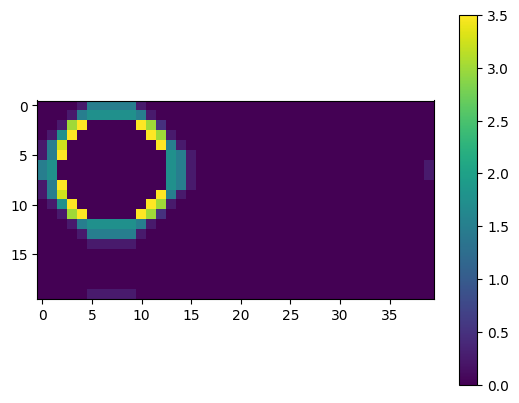

In [168]:
non_symmetric_cells = jnp.abs((resuling_matrix - resuling_matrix.T)).sum(axis = 1).reshape((20,40))
plt.imshow(non_symmetric_cells)
plt.colorbar()

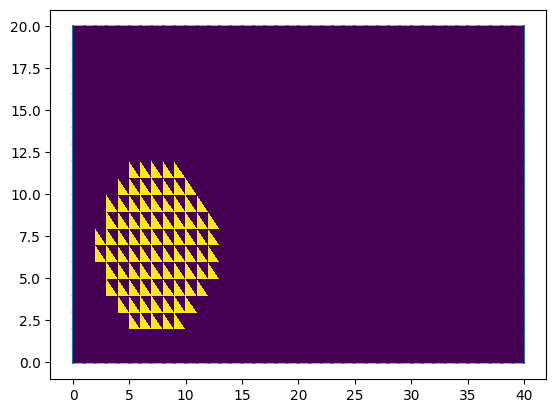

In [134]:
quatromatrix(1-  ba.state,1-ba.state, 0.5*non_symmetric_cells, 0.5*non_symmetric_cells)

In [89]:
((resuling_matrix - resuling_matrix.T) == 0).all()

Array(False, dtype=bool)

In [90]:
inverse_matrix = jnp.linalg.inv(resuling_matrix)

In [135]:
answer_eigy = jnp.linalg.eigh(resuling_matrix)

In [92]:
resuling_matrix.sum(axis = 0)

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [93]:
answer_eigy[1].shape

(800, 800)

In [136]:
(answer_eigy[1] @ jnp.diag(answer_eigy[0]) @ answer_eigy[1].T- resuling_matrix).std()

Array(2.3170836e-07, dtype=float32)

In [137]:
(answer_eigy[1] @ jnp.diag( answer_eigy[0]) @ answer_eigy[1].T)

Array([[-3.99999976e+00,  1.00000060e+00, -2.45869160e-07, ...,
        -2.94297934e-07,  9.16421413e-07,  4.17232513e-07],
       [ 1.00000060e+00, -4.00000381e+00,  1.00000072e+00, ...,
        -4.09781933e-08,  4.39584255e-07,  2.83122063e-07],
       [-2.79396772e-07,  1.00000072e+00, -4.00000095e+00, ...,
        -4.92203981e-07, -4.56348062e-08, -5.28991222e-07],
       ...,
       [-2.53319740e-07, -1.49011612e-08, -4.88478690e-07, ...,
        -4.00000000e+00,  9.99999881e-01, -8.56816769e-08],
       [ 8.86619091e-07,  4.54485416e-07, -1.21071935e-08, ...,
         9.99999881e-01, -4.00000000e+00,  1.00000155e+00],
       [ 4.13507223e-07,  2.53319740e-07, -4.99188900e-07, ...,
        -7.07805157e-08,  1.00000155e+00, -3.99999881e+00]],      dtype=float32)

In [138]:
((resuling_matrix @ answer_eigy[1] ) / answer_eigy[0] - answer_eigy[1]).std()

Array(0.00434002, dtype=float32)

In [139]:
jnp.diag(answer_eigy[0])

Array([[-7.9912043,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       , -7.964638 ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       , -7.9332623, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  1.000002 ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  1.0000024,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         1.0000031]], dtype=float32)

In [38]:
answer_eigy[1]

Array([[ 5.61728282e-03, -1.42453075e-03, -9.77197755e-03, ...,
         2.64779059e-03, -1.23396181e-04,  1.21242527e-04],
       [ 4.38968167e-02, -2.12703403e-02, -1.06012926e-01, ...,
        -4.06566029e-03,  2.17686204e-04, -2.15580003e-04],
       [-9.76635888e-03,  2.24436726e-03,  1.72252543e-02, ...,
         8.86638649e-03, -4.43182886e-04,  4.30834130e-04],
       ...,
       [ 1.00563122e-02,  1.95349474e-03, -3.13698426e-02, ...,
         1.97820948e-04, -8.44078022e-06,  1.00485049e-05],
       [ 5.34384453e-04, -1.38720497e-06, -9.68857855e-03, ...,
        -3.07331327e-04,  1.11989211e-05, -1.35803130e-05],
       [-1.52332028e-02, -2.02495325e-03,  4.11142036e-02, ...,
         7.38967501e-04, -3.62017308e-05,  4.01295838e-05]],      dtype=float32)

In [98]:
answer_eigy[0][714]

Array(-0.01242662, dtype=float32)

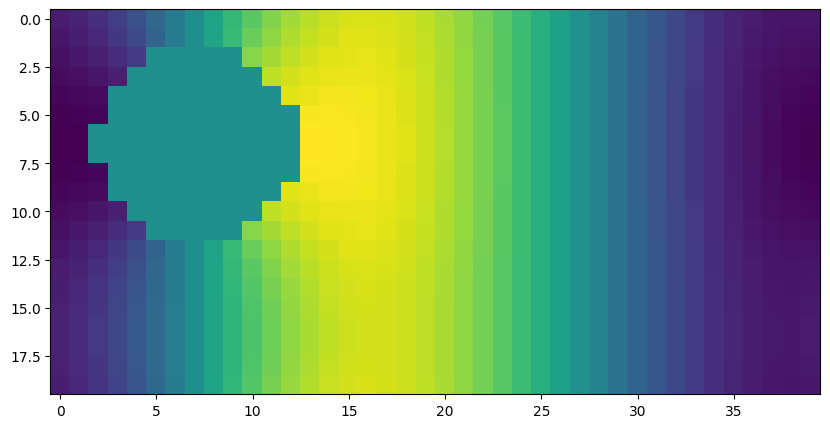

In [140]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow( answer_eigy[1][:,714].reshape(20,40) )

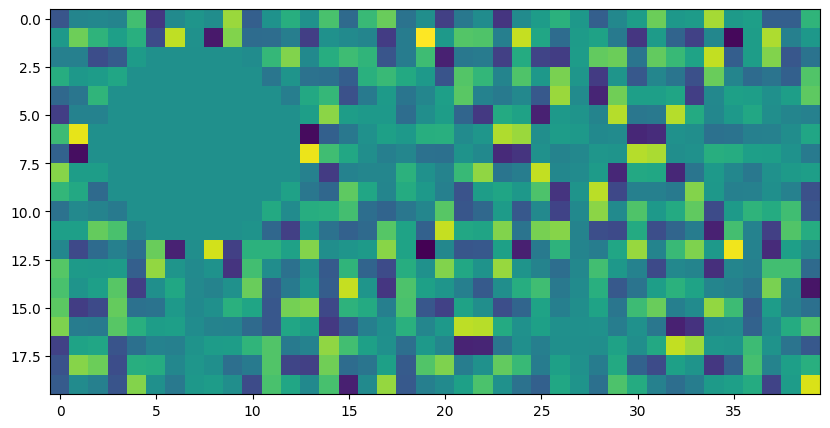

In [141]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow( answer_eigy[1][:,400].reshape(20,40) )

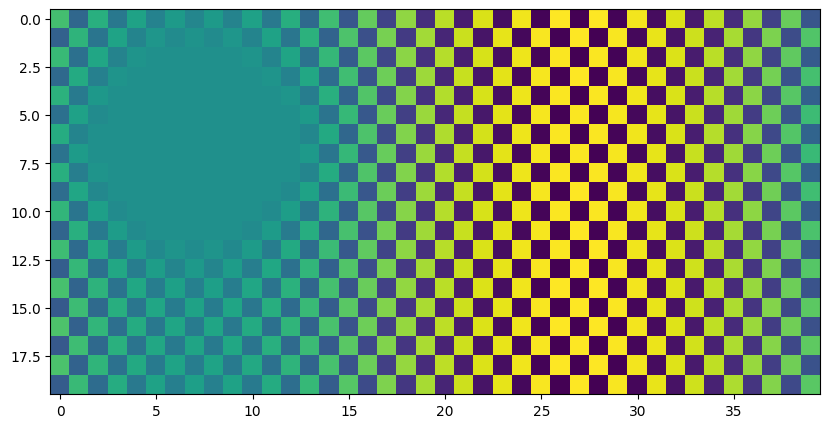

In [142]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow( answer_eigy[1][:,0].reshape(20,40) )

In [43]:
jnp.sum(jnp.log( jnp.abs(answer_eigy[0])) )

Array(341.08682, dtype=float32)

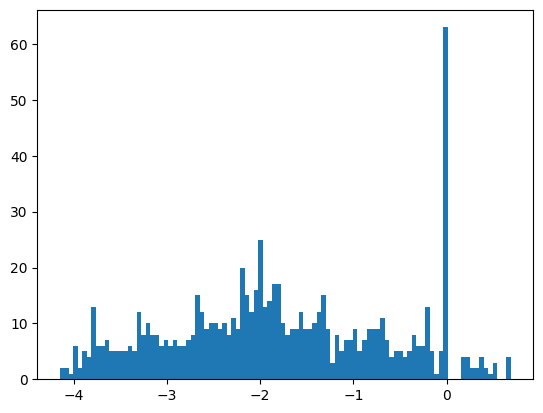

In [105]:
O = plt.hist(answer_eigy[0], bins = 100)

In [45]:
resuling_matrix

Array([[-2. ,  0. ,  0.5, ...,  0. ,  0. ,  0. ],
       [ 0. , -2. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0.5,  0. , -2. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ..., -2. ,  0. ,  0.5],
       [ 0. ,  0. ,  0. , ...,  0. , -2. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0.5,  0. , -2. ]], dtype=float32)

In [46]:
resuling_matrix

Array([[-2. ,  0. ,  0.5, ...,  0. ,  0. ,  0. ],
       [ 0. , -2. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0.5,  0. , -2. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ..., -2. ,  0. ,  0.5],
       [ 0. ,  0. ,  0. , ...,  0. , -2. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0.5,  0. , -2. ]], dtype=float32)

In [47]:
inverse_matrix @ resuling_matrix

Array([[ 9.8828125e-01, -9.7656250e-04, -8.7890625e-03, ...,
         1.3671875e-02,  2.9296875e-03,  1.9531250e-03],
       [ 9.7656250e-04,  9.9804688e-01, -2.9296875e-03, ...,
         2.9296875e-02,  3.9062500e-03, -3.9062500e-03],
       [-5.8593750e-03,  3.9062500e-03,  9.9121094e-01, ...,
         1.5625000e-02,  7.8125000e-03,  5.8593750e-03],
       ...,
       [ 3.9062500e-03, -1.9531250e-03, -5.8593750e-03, ...,
         1.0195312e+00,  0.0000000e+00,  3.9062500e-03],
       [ 4.8828125e-03,  0.0000000e+00, -8.7890625e-03, ...,
         1.9531250e-02,  1.0000000e+00,  0.0000000e+00],
       [ 5.8593750e-03,  1.9531250e-03, -9.7656250e-03, ...,
         1.9531250e-02,  3.9062500e-03,  1.0019531e+00]], dtype=float32)

In [48]:
jnp.unique(jnp.array(resuling_matrix, dtype=jnp.int32), return_counts=True)

(Array([-3, -2, -1,  0,  1], dtype=int32),
 Array([     6,    682,     70, 639074,    168], dtype=int32))

In [49]:
v[1].shape

(20, 40)

(20, 40)


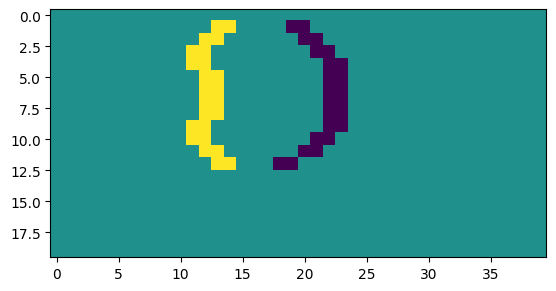

In [50]:
res = ba.divergence(v)
print(res.shape)

plt.imshow(ba.divergence(v))

# test divfree projection with boundary condidtions

In [260]:
#from problem import *



def project_divergencefree2(v, q_guess=None, state=None, fluid_neighbours=None, cg_runs = 2):

    ba = BoundaryAware(state, fluid_neighbours)

    q, _ = jsp.sparse.linalg.cg(
            ba.laplacian,
            -ba.divergence(v), 
            x0=q_guess)

    v_f = (v + ba.gradient(state*q))
    # Repeats as conjugate gradient descent does not necessarily converge to correct solution after 1 run
    for i in range(cg_runs):
        # q is the exact "pressure" needed to maintain densities
        qi, _ = jsp.sparse.linalg.cg(
            ba.laplacian,
            -ba.divergence(v_f), 
            maxiter= 1000)
        #q_total += q
        v_f += ba.gradient(qi)

    return v_f, q
    #return  q
    #return v + gradient(q)


In [261]:
# Initial conditions

v = jnp.zeros((2, lat.shape[0], lat.shape[1]))
v = v.at[1].set( -1 * ((jnp.square(lat+0.5) + jnp.square(lng+0.5))<1) )


state = 1 - 1 * ((jnp.square(lat+0.5) + jnp.square(lng+2))<0.7)
v*=state

fluid_neighbours = neighbours(state)

ba = BoundaryAware(state, fluid_neighbours)


Text(0.5, 1.0, 'blurred horizontal v')

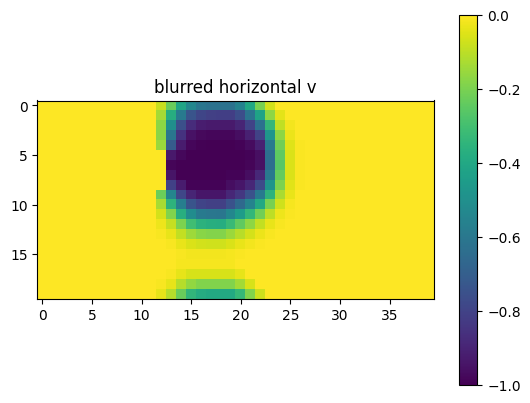

In [266]:
def blur(arr):
    return (jnp.roll(arr,  1, axis=-2)
          + jnp.roll(arr, -1, axis=-2)
          + jnp.roll(arr,  1, axis=-1)
          + jnp.roll(arr, -1, axis=-2)
          + arr) / (fluid_neighbours + 1 + 1-state) *state

v = blur(v)
#v = v.at[:,state==0].set(0)
plt.imshow(v[1])
plt.colorbar()
plt.title('blurred horizontal v')

Text(0.5, 1.0, 'divergence of v')

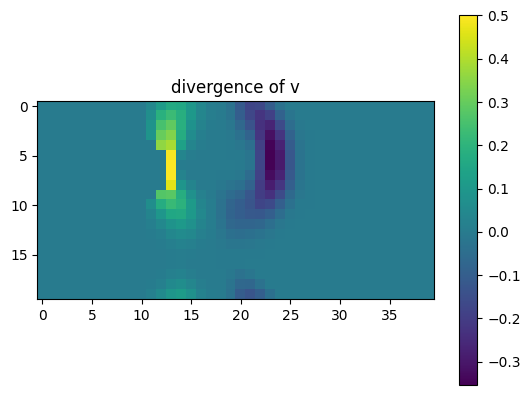

In [267]:
plt.imshow(ba.divergence(v))
plt.colorbar()
plt.title('divergence of v')

In [255]:
print(jnp.sum(ba.divergence(v*state)))
print(jnp.sum(problem.divergence(v)))

-3.3253336
9.536743e-07


-0.8222684 0.4570884


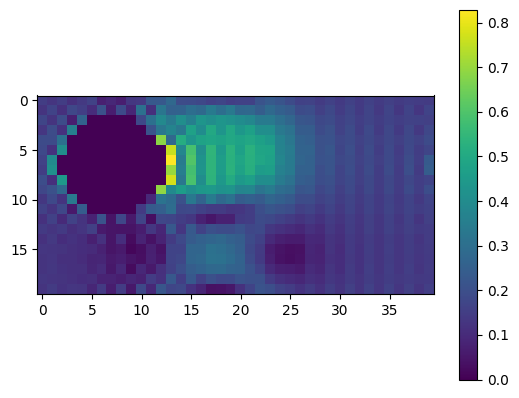

In [268]:
def normv(v): return jnp.sqrt(jnp.square(v[0]) + jnp.square(v[1]))

v_f, q1 = project_divergencefree2(v, state=state, fluid_neighbours = fluid_neighbours, cg_runs = 2)

print(jnp.amin(v_f), jnp.amax(v_f))

plt.imshow((normv(v_f)))
plt.colorbar()

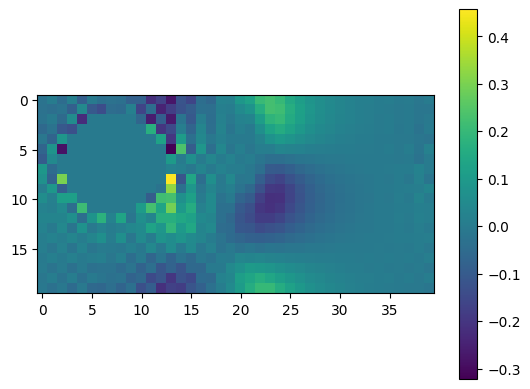

In [269]:
plt.imshow(v_f[0])
plt.colorbar()

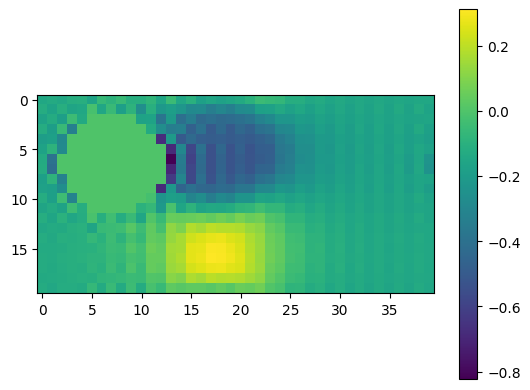

In [270]:
plt.imshow(v_f[1])
plt.colorbar()

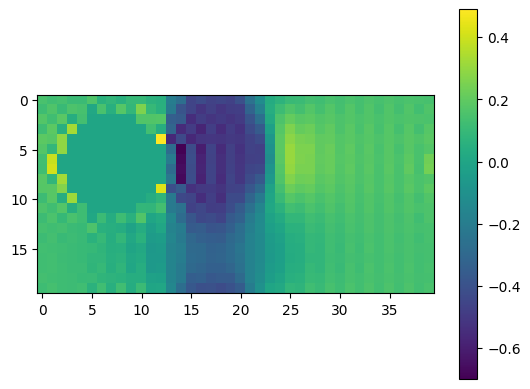

In [226]:
plt.imshow(-ba.plambda(q1))
plt.colorbar()

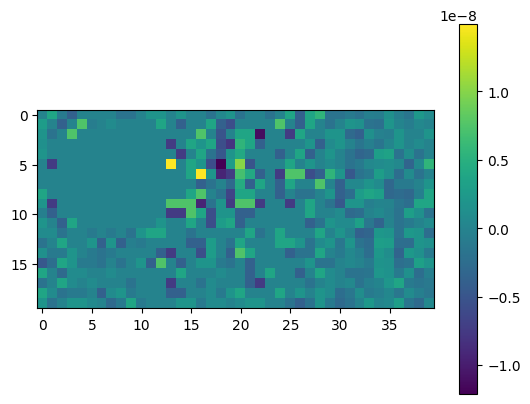

In [272]:
plt.imshow(ba.divergence(v_f))
plt.colorbar()

# test conjugate gradient on underdetermined system

In [61]:
A  = jnp.eye(5)
A  = A.at[3:5,3:5].set(0)
print(A)

b = jnp.ones((5,1))
print(b)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [62]:
jax.scipy.sparse.linalg.cg(A, b, maxiter=1)

(Array([[1.6666666],
        [1.6666666],
        [1.6666666],
        [1.6666666],
        [1.6666666]], dtype=float32),
 None)

# bathymetry

In [63]:
import numpy as np

In [64]:
# Assuming `data` is your N-dimensional numpy array
data = np.random.rand(10, 20, 30)  # Example: 3D array
print('data created')

def plot_slice(x=0):
    plt.imshow(data[:, :, x], interpolation='nearest')
    plt.show()

interact(plot_slice, x=IntSlider(min=0, max=data.shape[2]-1, step=1, value=0))

data created


NameError: name 'interact' is not defined

opening path  /mnt/c/Users/spenc/OneDrive/Documents/GitHub/THCsim/resources/map/gebco_08_rev_bath_3600x1800_color.jpg
/mnt/c/Users/spenc/OneDrive/Documents/GitHub/THCsim/resources/map/gebco_08_rev_bath_3600x1800_color.jpg
(1800, 3600, 3)


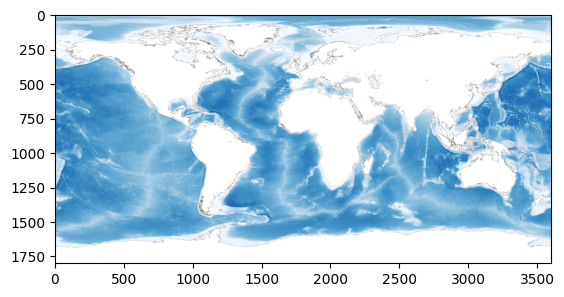

In [ ]:
import cv2
import numpy as np
import os

def get_map_path(config):

    if config["map"]["mask_image_path_relative"]:
        print('opening path ', os.path.join( os.getcwd(), config["map"]["mask_image_path"] ))
        print(os.path.join( os.getcwd(), config["map"]["mask_image_path"] ))
        return os.path.join( os.getcwd(), config["map"]["mask_image_path"] )
    else:
        return config["map"]["mask_image_path"]


def load_np(config):

    image_np = cv2.imread(get_map_path(config)) 

    return image_np[:,:,::-1]



import matplotlib.pyplot as plt

config = {"map": {"mask_image_path_relative": True, 
                    "mask_image_path": "resources/map/gebco_08_rev_bath_3600x1800_color.jpg"}}

im = load_np(config).astype(int)
print(im.shape)

im[:,:,:] += (np.isclose(im[:,:,0],im[:,:,2], atol=4))[:,:,np.newaxis]*255

im[im>255]=255

plt.imshow(im)
#plt.show()